Epoch 000, Loss: 2.2182, Train Acc: 0.1000, Val Acc: 0.1520, Test Acc: 0.1240
Epoch 020, Loss: 1.4507, Train Acc: 0.4500, Val Acc: 0.6900, Test Acc: 0.6930
Epoch 040, Loss: 0.9626, Train Acc: 0.7357, Val Acc: 0.7460, Test Acc: 0.7330
Epoch 060, Loss: 0.8910, Train Acc: 0.7357, Val Acc: 0.7140, Test Acc: 0.7250
Epoch 080, Loss: 0.6532, Train Acc: 0.8071, Val Acc: 0.7180, Test Acc: 0.7340
Epoch 100, Loss: 0.6171, Train Acc: 0.8000, Val Acc: 0.7460, Test Acc: 0.7550
Epoch 120, Loss: 0.5563, Train Acc: 0.8571, Val Acc: 0.7440, Test Acc: 0.7610
Epoch 140, Loss: 0.5378, Train Acc: 0.8429, Val Acc: 0.7460, Test Acc: 0.7560
Epoch 160, Loss: 0.6581, Train Acc: 0.7429, Val Acc: 0.7480, Test Acc: 0.7600
Epoch 180, Loss: 0.5964, Train Acc: 0.8000, Val Acc: 0.7280, Test Acc: 0.7600
Epoch 200, Loss: 0.5649, Train Acc: 0.8071, Val Acc: 0.7340, Test Acc: 0.7610
Epoch 220, Loss: 0.5695, Train Acc: 0.8071, Val Acc: 0.7400, Test Acc: 0.7570
Epoch 240, Loss: 0.5765, Train Acc: 0.7857, Val Acc: 0.7420, Tes

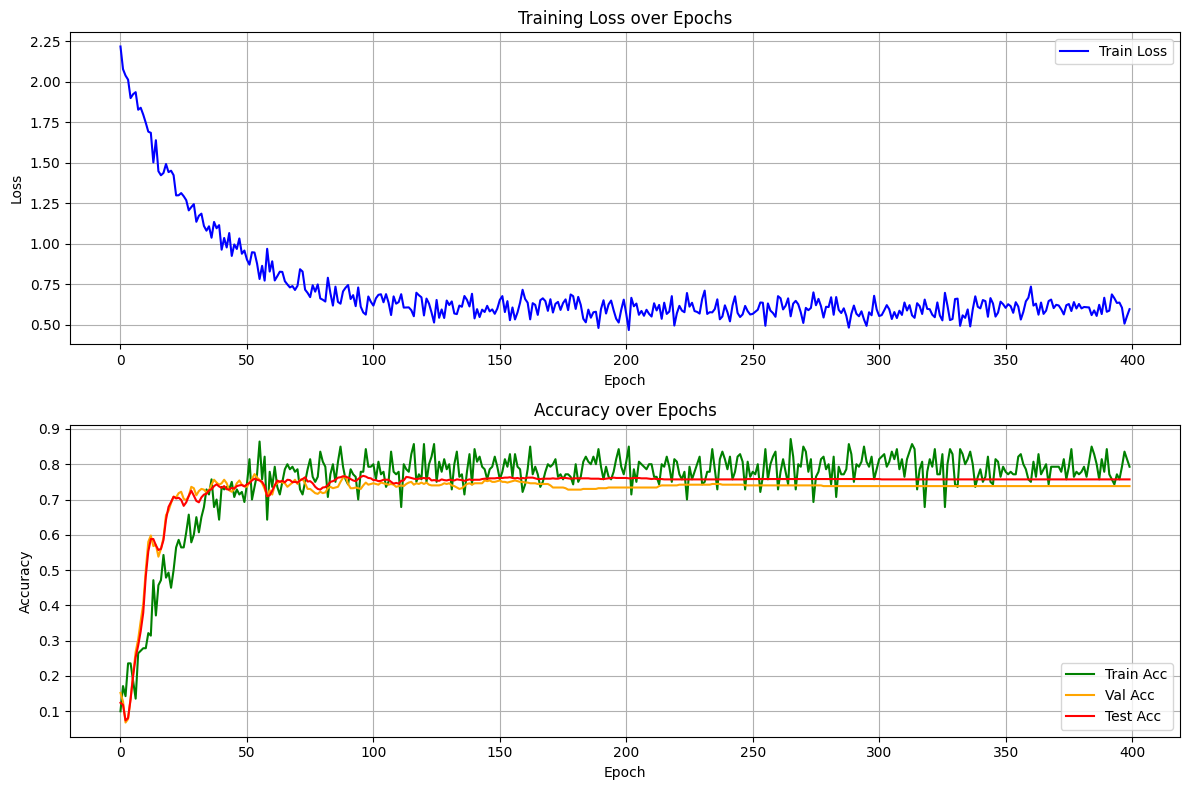

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt

dataset = Planetoid(root='/kaggle/working/Cora123', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

class MGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes):
        super().__init__()
        # 特征降维
        self.input_fc = nn.Linear(in_dim, hidden_dim)
        
        # 图卷积层
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # 注意力机制
        self.growth_fc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.growth_weight = nn.Linear(hidden_dim, 1)
        
        # 全局信号
        self.signal_coord = nn.Linear(hidden_dim, hidden_dim)
        
        # 层归一化（路径优化）
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        # 输出层
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        # 特征降维
        x = F.relu(self.input_fc(x))
        
        # 第一层图卷积
        h = self.conv1(x, edge_index)
        h = self.norm1(h)  # 层归一化
        h = F.relu(h)
        h = self.dropout(h)

        edge_src, edge_dst = edge_index
        h_src = h[edge_src]
        h_dst = h[edge_dst]
        growth_input = torch.cat([h_src, h_dst], dim=-1)
        growth_hidden = F.relu(self.growth_fc(growth_input))
        growth_scores = torch.softmax(self.growth_weight(growth_hidden), dim=0)  # Softmax 确保稳定性
        
        # 加权聚合邻居
        h_agg = torch.zeros_like(h)
        h_agg.index_add_(0, edge_dst, h_src * growth_scores)
        
        # 第二层图卷积（带残差连接）
        h_residual = h
        h = self.conv2(h_agg, edge_index) + h_residual  # 残差连接
        h = self.norm2(h)  # 层归一化
        h = F.relu(h)
        h = self.dropout(h)
        
        # 全局化学信号
        signal = torch.mean(h, dim=0, keepdim=True)
        signal = F.relu(self.signal_coord(signal))
        h = h + signal
        
        # 输出分类
        out = self.classifier(h)
        return out

# 设备和模型初始化
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MGNN(in_dim=dataset.num_features, hidden_dim=32, num_classes=dataset.num_classes).to(device)
data = data.to(device)

# 优化器、损失函数和学习率调度
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=20, verbose=True)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accs = []
val_accs = []
test_accs = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 梯度裁剪
    optimizer.step()
    
    pred = out.argmax(dim=1)
    train_acc = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    return loss.item(), train_acc

def validate():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    return val_acc

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    return acc

for epoch in range(400):
    loss, train_acc = train()
    val_acc = validate()
    test_acc = test()
    

    train_losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    

    scheduler.step(val_acc)
    
    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')


final_acc = test()
print(f'Final Test Accuracy: {final_acc:.4f}')


print(f"Train nodes: {data.train_mask.sum().item()}")
print(f"Val nodes: {data.val_mask.sum().item()}")
print(f"Test nodes: {data.test_mask.sum().item()}")

epochs = range(400)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accs, label='Train Acc', color='green')
plt.plot(epochs, val_accs, label='Val Acc', color='orange')
plt.plot(epochs, test_accs, label='Test Acc', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [44]:

from sklearn.metrics import roc_auc_score, f1_score
import torch.nn.functional as F

def evaluate():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1).cpu().numpy()
        true = data.y.cpu().numpy()
        prob = F.softmax(out, dim=1).cpu().numpy()

    auc_roc = roc_auc_score(
        F.one_hot(torch.tensor(true), num_classes=dataset.num_classes).numpy(),
        prob,
        average="macro",
        multi_class="ovr"
    )

    f1 = f1_score(true, pred, average="macro")

    return auc_roc, f1

auc_roc, f1 = evaluate()
print(f"AUC-ROC: {auc_roc:.4f}, F1-score: {f1:.4f}")



AUC-ROC: 0.9412, F1-score: 0.7563
